# Election Twitter Anlysis
## Data Process for two provided twitter files

#### Tweets Scrapped xlsx file

In [3]:
# !pip install ftfy
# !pip install vaderSentiment

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
# Data Set One
tweets_data_first = pd.read_excel('Tweets Scrapped US Elections 2024.xlsx')
tweets_data_first

,Account Name,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets
0,WTFGOP,I literally have people freaking out & texting...,2011-10-01 00:00:00,122,20.3K,2836
1,Bishop Paul S Morton,As a Black Man I definitely could not support ...,2011-10-01 00:00:00,305,23.3K,3653
2,SANJOSEMAILMAN,Some hardcore Trump supporters in North Caroli...,2010-10-01 00:00:00,115,85K,4925
3,GoldStarMom,I cast my ballot today for Donald J Trump.,2011-10-01 00:00:00,416,74.4K,6925
4,Aes,Harris keeps overperforming in districts Biden...,2010-10-01 00:00:00,88,33.9K,2416
...,...,...,...,...,...,...
986,Captain Renault,Of the six high-profile media appearances by M...,Oct-06,2,382,73
987,Philip Anderson,FEMA are the scum of the earth,Oct-05,27,199,29
988,Mayor Levar M. Stoney,"Back in 2020, I worked around the clock to mak...",Oct-04,8,179,54
989,West Wing Report (Edited by Paul Brandu),1) National unemployment rate: 4.1% 2) It is l...,Oct-05,0,15,7


In [5]:
# no null data detected
tweets_data_first.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Account Name     991 non-null    object
 1   Tweet            991 non-null    object
 2   Date             991 non-null    object
 3   No. of Replies   991 non-null    object
 4   No. of Likes     991 non-null    object
 5   No. of Retweets  991 non-null    object
dtypes: object(6)
memory usage: 46.6+ KB


In [6]:
tweets_data_first['Date'] = tweets_data_first['Date'].astype(str)
set(tweets_data_first['Date'])

{'2003-10-01 00:00:00',
 '2004-10-01 00:00:00',
 '2005-10-01 00:00:00',
 '2006-10-01 00:00:00',
 '2007-10-01 00:00:00',
 '2008-10-01 00:00:00',
 '2009-10-01 00:00:00',
 '2010-10-01 00:00:00',
 '2011-10-01 00:00:00',
 'Oct-02',
 'Oct-04',
 'Oct-05',
 'Oct-06'}

For this dataset, there appear to be **some data quality issues.** Many tweets are dated from years like 2003 and 2011, which are too far to **meaningfully impact** the sentiment analysis for the 2024 elections. **Yet after careful examination it seems to be excel identification issues (Trump was not in office by 2011), we have to clean date format as the first step**

In [7]:
# Helper function for date conversion
def date_conversion(string):
    try:
        # Handle 'YYYY-MM-DD HH:MM:SS' dates directly
        date = pd.to_datetime(string, errors='coerce', format='%Y-%m-%d %H:%M:%S')

        # If the date is valid (not NaT), adjust it to 2024 with a modified day based on the last two digits of the original year
        if not pd.isna(date):
            original_year_last_two_digits = int(str(date.year)[-2:])
            day = min(max(1, original_year_last_two_digits), 31)
            return date.replace(year=2024, day=day)

        # Handle 'Oct-02' style dates by appending the year 2024
        if '-' in string and len(string.split('-')[1]) == 2:
            return pd.to_datetime(f"{string} 2024", format='%b-%d %Y', errors='coerce')

    except Exception as e:
        # If any parsing error occurs, print it for debugging and return NaT
        print(f"Error parsing date '{string}': {e}")
        return pd.NaT

    # If the string is unrecognized or an error occurs, return NaT
    return pd.NaT


tweets_data_first['Date'] = tweets_data_first['Date'].apply(date_conversion)
tweets_data_first = tweets_data_first.drop('Account Name', axis = 1)
tweets_data_first.head()

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets
0,I literally have people freaking out & texting...,2024-10-11,122,20.3K,2836
1,As a Black Man I definitely could not support ...,2024-10-11,305,23.3K,3653
2,Some hardcore Trump supporters in North Caroli...,2024-10-10,115,85K,4925
3,I cast my ballot today for Donald J Trump.,2024-10-11,416,74.4K,6925
4,Harris keeps overperforming in districts Biden...,2024-10-10,88,33.9K,2416


**The number of likes/ No. of Retweets**  seems to be non-numeric lets **convert it**

In [8]:
print(type(tweets_data_first['No. of Likes'][0]))
def convert_likes(value):
    """
    Convert a string representation of likes with 'K' or 'M' into an integer.

    This function processes a string that represents the number of likes,
    where 'K' denotes thousands (e.g., '20.3K' becomes 20300) and 'M' denotes millions
    (e.g., '15M' becomes 15000000). It replaces 'K' with '000' and 'M' with '000000'
    and removes any decimal points before converting the resulting string into an integer.
    If the input is already an integer, it returns the value unchanged.
    If the value is '-', an empty string, or NaN, it returns 0.

    Parameters:
    ----------
    value : str, int, or float
        A string or integer representing the number of likes, e.g., '20.3K', '85K', '15M', or 85000.

    Returns:
    -------
    int
        The numeric representation of likes as an integer.

    Example:
    -------
    >>> convert_likes('20.3K')
    20300
    >>> convert_likes('85K')
    85000
    >>> convert_likes('15M')
    15000000
    >>> convert_likes(85000)
    85000
    >>> convert_likes('-')
    0
    >>> convert_likes(float('nan'))
    0
    """
    if pd.isna(value) or value in {'-', ''}:
        return 0
    if isinstance(value, int):
        return value
    elif 'K' in value:
        value = value.replace('K', '000').replace('.', '')
    elif 'M' in value:
        value = value.replace('M', '000000').replace('.', '')
    return int(value)

<class 'str'>


In [9]:
# Apply the function to the 'No. of Likes' column
tweets_data_first['No. of Likes'] = tweets_data_first['No. of Likes'].apply(convert_likes)
tweets_data_first['No. of Retweets'] = tweets_data_first['No. of Retweets'].apply(convert_likes)
# Verify the conversion
print(tweets_data_first[['No. of Likes']].head())

   No. of Likes
0        203000
1        233000
2         85000
3        744000
4        339000


In [10]:
# report date values for dataset one
print(tweets_data_first['Date'].value_counts())
tweet_data_first = tweets_data_first.sort_values('Date')

Date
2024-10-11    203
2024-10-10    160
2024-10-05    147
2024-10-09    127
2024-10-06    126
2024-10-04    102
2024-10-08     63
2024-10-07     42
2024-10-02     20
2024-10-03      1
Name: count, dtype: int64


**Engagement metrics like replies, likes, and retweets are crucial in analyzing the impact of a tweet.** A tweet with higher engagement typically indicates greater interest and influence among the audience, making it more impactful.

Using these metrics to assign weights allows for identifying which tweets resonate more with followers and understanding their influence on discussions.

However, determining the appropriate weights for each metric is not straightforward. For sub-data one I have decided to goup data by date and then apply quantile method

**Using quantile ranks to evaluate tweet engagement is effective** because it assesses each tweet's performance relative to others from the same day, ensuring fairness across varying daily activity levels.

Quantile ranks range from 0 (lowest engagement) to 1 (highest engagement), allowing for a normalized comparison. Averaging these ranks across replies, likes, and retweets balances the influence of each metric, offering a comprehensive measure of engagement without overemphasizing any single aspect.

In [11]:
def calculate_quantile_ranks(group):
    """
    Calculate the quantile ranks for replies, likes, and retweets, and compute an average quantile score.

    This function takes a DataFrame grouped by a specific key (e.g., Date) and calculates the quantile rank
    of each tweet's engagement metrics (replies, likes, and retweets) relative to other tweets within the same group.
    The quantile ranks are values between 0 and 1, indicating the relative standing of each tweet within the group.
    An average quantile score is then computed by taking the mean of the quantile ranks for replies, likes, and retweets.

    Parameters:
    -----------
    group : pandas.DataFrame
        A DataFrame containing the engagement metrics (No. of Replies, No. of Likes, No. of Retweets) for each tweet,
        grouped by a specific key (such as Date).

    Returns:
    --------
    pandas.DataFrame
        The input DataFrame with added columns:
        - "Quantile_Replies": Quantile rank of the number of replies within the group.
        - "Quantile_Likes": Quantile rank of the number of likes within the group.
        - "Quantile_Retweets": Quantile rank of the number of retweets within the group.
        - "Average_Quantile_Score": The average of the three quantile ranks, providing a balanced measure of engagement.

    Example:
    --------
    # Sample data
    data = {
        "Tweet": ["Tweet1", "Tweet2", "Tweet3"],
        "Date": ["2024-10-02", "2024-10-02", "2024-10-02"],
        "No. of Replies": [10, 5, 20],
        "No. of Likes": [100, 200, 150],
        "No. of Retweets": [50, 60, 30]
    }
    df = pd.DataFrame(data)

    # Group by 'Date' and apply the function
    df = df.groupby("Date").apply(calculate_quantile_ranks)

    # Resulting DataFrame:
    #         Tweet       Date  No. of Replies  No. of Likes  No. of Retweets  Quantile_Replies  Quantile_Likes  Quantile_Retweets  Average_Quantile_Score
    # 0      Tweet1  2024-10-02              10            100               50              0.5            0.00               0.5                 0.3333
    # 1      Tweet2  2024-10-02               5            200               60              0.0            1.00               1.0                 0.6667
    # 2      Tweet3  2024-10-02              20            150               30              1.0            0.50               0.0                 0.5000

    In this example, each tweet's engagement metrics are ranked relative to the other tweets on the same date. The quantile ranks for each metric are calculated, and an average score is computed, providing a balanced view of overall engagement.
    """
    # Convert engagement metrics to numeric, replacing errors with 0
    group["No. of Replies"] = pd.to_numeric(group["No. of Replies"], errors='coerce').fillna(0)
    group["No. of Likes"] = pd.to_numeric(group["No. of Likes"], errors='coerce').fillna(0)
    group["No. of Retweets"] = pd.to_numeric(group["No. of Retweets"], errors='coerce').fillna(0)

    # Calculate the quantile ranks
    group["Quantile_Replies"] = group["No. of Replies"].rank(pct=True)
    group["Quantile_Likes"] = group["No. of Likes"].rank(pct=True)
    group["Quantile_Retweets"] = group["No. of Retweets"].rank(pct=True)

    # Calculate the average quantile score
    group["Engagement_Score"] = (
        group["Quantile_Replies"] +
        group["Quantile_Likes"] +
        group["Quantile_Retweets"]
    ) / 3

    return group

One thing we should have noticed is that data set one along is *quite limited. *There are another suplmentary data provided by professor left unexplored. A correct way of doing so will be analyze the second data before polarity computing, merge them, compute Engagment Score (CHECK CORRECTNESS OF THIS METHODOLOGY) and then to conduct analysis

#### tweets_Presidential_Election_data_Oct15_2024.csv

In [12]:
tweets_data_second = pd.read_csv('tweets_Presidential_Election_data_Oct15_2024.csv')
tweets_data_second

,Date,Time,Tweet ID,Conversation ID,In Reply To User ID,Language,Source,Possibly Sensitive,Reply Settings,Text,...,Profile Image URL,Author Verified,Author Location,Followers Count,Following Count,Total Tweet Count,Number of Likes,Number of Replies,Number of Retweets,Number of Quotes
0,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @ProjectLincoln: Every time Trump speaks. h...,...,https://pbs.twimg.com/profile_images/182894700...,False,USA,275,1286,31347,0,0,733,0
1,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @PalmerReport: Senile Donald Trump stops to...,...,https://pbs.twimg.com/profile_images/179518461...,False,NaN,48,113,1822,0,0,1964,0
2,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @KamalaHQ: NEW: Over 250 doctors and health...,...,https://pbs.twimg.com/profile_images/178037074...,False,Coastal Maine,1633,3021,21858,0,0,6420,0
3,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @ByronCDerrick: @KamalaHQ Pretty obvious Tr...,...,https://pbs.twimg.com/profile_images/172314453...,False,NaN,306,233,5486,0,0,113,0
4,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,"RT @kylenabecker: JUST IN: Vem Miller, the man...",...,https://pbs.twimg.com/profile_images/170651708...,False,Road Runner Ranch,3657,2464,194724,0,0,4702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6981,10/9/2024,11:42:31,1.843980e+18,1.843750e+18,1.070000e+18,en,NaN,False,everyone,@TwinTowerCity @realDonaldTrump Have you had t...,...,https://pbs.twimg.com/profile_images/158961907...,False,NaN,246,967,5497,1,0,0,0
6982,10/9/2024,11:42:31,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,RT @CalltoActivism: ðŸš¨ðŸš¨ðŸš¨MAJOR BREAKING...,...,https://pbs.twimg.com/profile_images/180022912...,False,NaN,463,549,26120,0,0,23616,0
6983,10/9/2024,11:42:30,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,RT @danhanley4: Trump is an Israeli Jew ass ki...,...,https://pbs.twimg.com/profile_images/177584277...,False,"manila, philippines",174,297,10930,0,0,190,0
6984,10/9/2024,11:42:30,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,"RT @djrothkopf: So, let me get this straight, ...",...,https://pbs.twimg.com/profile_images/547610188...,False,NaN,1723,822,42311,0,0,16273,0


In [13]:
tweets_data_second['Text']
# Text are messy and requires cleaning

,Text
0,RT @ProjectLincoln: Every time Trump speaks. h...
1,RT @PalmerReport: Senile Donald Trump stops to...
2,RT @KamalaHQ: NEW: Over 250 doctors and health...
3,RT @ByronCDerrick: @KamalaHQ Pretty obvious Tr...
4,"RT @kylenabecker: JUST IN: Vem Miller, the man..."
...,...
6981,@TwinTowerCity @realDonaldTrump Have you had t...
6982,RT @CalltoActivism: ðŸš¨ðŸš¨ðŸš¨MAJOR BREAKING...
6983,RT @danhanley4: Trump is an Israeli Jew ass ki...
6984,"RT @djrothkopf: So, let me get this straight, ..."


It seems obvious that the text is messy due to **a few key issues.** It includes unstructured, has an inconsistent format, mixing user mentions (e.g., @TwinTowerCity), hashtags, and special characters (like ÖŸ), which might be due to encoding errors or handling of non-ASCII characters. Additionally, the mixture of tweets from different users and contexts makes analysis challenging without further processing. The noise introduced by retweets (RT) and repeated user mentions adds another layer of complexity, requiring cleanup for effective analysis.

In [14]:
# Comment: Seems no empty text before we clean
empty_text_count = tweets_data_second['Text'].isna().sum() + (tweets_data_second['Text'] == '').sum()
print(f'The number of empty or NaN texts: {empty_text_count}')

The number of empty or NaN texts: 0


##### Vadar can identify upper case, marks and emojis like what professor machined in the lecture so it might be good to change them first before cleaning tweet

ftfy library: ftfy stands for "fixes text for you." It is a Python library designed to automatically correct text encoding issues, especially those caused by incorrect character decoding or mojibake (garbled characters). It can detect and convert text that was wrongly decoded using the wrong character sets back into a readable form.

fix_text function: This function from the ftfy library attempts to repair text that appears garbled or misencoded. It can fix common issues such as characters displayed incorrectly due to mismatched encodings.

Whitespace normalization: After fixing the text, the function removes extra spaces and ensures there’s only a single space between words using a regular expression with re.sub.

In [15]:
from ftfy import fix_text
def clean_with_ftfy(text):
    """
    Clean and normalize garbled or misencoded text using the ftfy library.

    This function attempts to automatically fix encoding issues in the given
    text, such as mojibake or improperly decoded characters. After repairing
    the text, it normalizes spaces to ensure consistent spacing between words.

    Parameters:
    text (str): The input text that may contain garbled characters or encoding issues.

    Returns:
    str: The cleaned and normalized text with encoding issues fixed and extra
         whitespace removed.

    Example:
    >>> text = "Ã©lÃ¨ve and â€“ are garbled"
    >>> clean_with_ftfy(text)
    'élève and – are garbled'

    >>> text = "hello   world!  "
    >>> clean_with_ftfy(text)
    'hello world!'
    """
    # Automatically fix encoding issues using ftfy
    text = fix_text(text)
    # Normalize spaces and strip extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the function to the 'Text' column in the DataFrame
tweets_data_second['Text'] = tweets_data_second['Text'].apply(clean_with_ftfy)

# Display some of the cleaned text
print(tweets_data_second[['Text']])

                                                   Text
0     RT @ProjectLincoln: Every time Trump speaks. h...
1     RT @PalmerReport: Senile Donald Trump stops to...
2     RT @KamalaHQ: NEW: Over 250 doctors and health...
3     RT @ByronCDerrick: @KamalaHQ Pretty obvious Tr...
4     RT @kylenabecker: JUST IN: Vem Miller, the man...
...                                                 ...
6981  @TwinTowerCity @realDonaldTrump Have you had t...
6982  RT @CalltoActivism: 🚨🚨🚨MAJOR BREAKING: In a sh...
6983  RT @danhanley4: Trump is an Israeli Jew ass ki...
6984  RT @djrothkopf: So, let me get this straight, ...
6985  RT @TheRickWilson: Florida Republican Demands ...

[6986 rows x 1 columns]


In [16]:
def clean_tweet(text):
    """
    Clean the tweet text by removing RT, mentions, URLs.
    Parameters:
    ----------
    text : str
        The tweet text to be cleaned.

    Returns:
    -------
    str
        The cleaned tweet text with RT, mentions, URLs, special characters removed,
        and converted to lowercase.

    Example:
    -------
    >>> tweet = "RT @user123: Check this out! https://example.com #amazing 😊"
    >>> clean_tweet(tweet)
    'Check this out! amazing😊'
    """

    # Remove "RT" and mentions
    text = re.sub(r'\bRT\b', '', text)  # Remove "RT"
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@username)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove special characters and extra spaces
    #text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keep only letters, numbers, and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and trim

    # Convert to lowercase
    #text = text.lower()
    return text

# Apply the updated function to clean the 'Text' column
tweets_data_second['Cleaned_Text'] = tweets_data_second['Text'].apply(clean_tweet)

# Verify the first few cleaned tweets
print(tweets_data_second[['Text', 'Cleaned_Text']].head())

                                                Text  \
0  RT @ProjectLincoln: Every time Trump speaks. h...   
1  RT @PalmerReport: Senile Donald Trump stops to...   
2  RT @KamalaHQ: NEW: Over 250 doctors and health...   
3  RT @ByronCDerrick: @KamalaHQ Pretty obvious Tr...   
4  RT @kylenabecker: JUST IN: Vem Miller, the man...   

                                        Cleaned_Text  
0                         : Every time Trump speaks.  
1  : Senile Donald Trump stops town hall after a ...  
2  : NEW: Over 250 doctors and health care provid...  
3  : Pretty obvious Trump is fucking crazy. We co...  
4  : JUST IN: Vem Miller, the man accused of a so...  


In [17]:
empty_text_count = tweets_data_second['Cleaned_Text'].isna().sum() + (tweets_data_second['Cleaned_Text'] == '').sum()
print(f'The number of empty or NaN texts: {empty_text_count}')

The number of empty or NaN texts: 26


After Cleaning there seem to be cases of **empty string** let's check patterns of these 47 text. To see whether there is systematic issues

In [18]:
empty = tweets_data_second[tweets_data_second['Cleaned_Text'].isna() | (tweets_data_second['Cleaned_Text'] == '')]
for i in range(len(empty)):
  print(empty['Text'].iloc[i])

https://t.co/TRKCQsfZba
@RikLesel @crystal_ignite https://t.co/NxDdEadI8N
@BarbraStreisand https://t.co/rvHJ7EbXQy
@tribelaw https://t.co/8LtQdj1gdt
@DisavowTrump20 https://t.co/OdjVZ2WkFo
@harris_wins https://t.co/mK2yuXGhYJ https://t.co/TeFVtrsb3M
https://t.co/JLLe192n34
https://t.co/sdSIFGGedg
@tmacdazzle @DefiyantlyFree https://t.co/VfSLtkhYp3
@TRUMP_ARMY_ https://t.co/r25SCitcxu
@blockedfreq https://t.co/ttxqtFHl4k
https://t.co/d96ULelG4T
https://t.co/dUb0NHtepW
https://t.co/MRd4GNFEDV
@harris_wins https://t.co/TCcW3nHSmW
@harris_wins https://t.co/IFeEMBmzrK
https://t.co/hbKjBODIMO
https://t.co/Aa5l4qefP3
@harris_wins https://t.co/sFKiZReOsR
https://t.co/KyxLsipKJ3
https://t.co/i46t0fMXPg
https://t.co/5WkdxOB3Tp
@ginahens1 @DebbieSVA @VoteMarsha @KamalaHarris https://t.co/ZQDoLr3z8M
@Acyn https://t.co/9OZjKAVbHu https://t.co/sHB4kRfS8k
@TrumpDailyPosts https://t.co/OVHOxbiHgb https://t.co/L6SHwvSyPT
https://t.co/7mrbKQQ7Nw


In [19]:
tweets_data_second.iloc[6982]

,6982
Date,10/9/2024
Time,11:42:31
Tweet ID,1843980000000000000.0
Conversation ID,1843980000000000000.0
In Reply To User ID,NaN
Language,en
Source,NaN
Possibly Sensitive,False
Reply Settings,everyone
Text,RT @CalltoActivism: 🚨🚨🚨MAJOR BREAKING: In a sh...


The content is primarily uninformative, consisting mainly of URLs (e.g., https://t.co/...) and user mentions (e.g., @RikLesel, @harris_wins). These elements lack context, making them of little analytical value on their own. The repetitive nature of the structure further adds to the noise, as the text mainly repeats mentions and links without any narrative or meaningful content. Cleaning the data by removing these elements would be necessary to uncover any valuable insights.

Given their relatively **small proportion**, I believe it is reasonable to exclude them from our analysis.

In [20]:
tweets_data_second = tweets_data_second[~(tweets_data_second['Cleaned_Text'].isna() | (tweets_data_second['Cleaned_Text'] == ''))]
# Verify the result
print(f'The number of rows after removing empty or NaN Cleaned_Text: {len(tweets_data_second)}')
empty_text_count = tweets_data_second['Cleaned_Text'].isna().sum() + (tweets_data_second['Cleaned_Text'] == '').sum()
print(f'The number of empty or NaN texts: {empty_text_count}')

The number of rows after removing empty or NaN Cleaned_Text: 6960
The number of empty or NaN texts: 0


In [21]:
set(tweets_data_second['Language'])

{'ar',
 'ca',
 'cs',
 'cy',
 'de',
 'en',
 'es',
 'et',
 'eu',
 'fr',
 'hi',
 'ht',
 'hu',
 'in',
 'it',
 'ja',
 'lv',
 'nl',
 'no',
 'pl',
 'pt',
 'qht',
 'qme',
 'ro',
 'sv',
 'tl',
 'tr',
 'und',
 'vi',
 'zh'}

It also seems that there **some other language present** here, it may be a good practice to translate them into english

We use the deep-translator library for its versatility and reliability in translating text between various languages. Unlike some alternatives that rely on browser-based services or web scraping, deep-translator directly connects to multiple translation providers, including Google Translate, Microsoft, and Yandex, offering users the flexibility to choose the best service for their needs. This makes it particularly useful for automating translation tasks in data processing workflows, such as multilingual text analysis, sentiment analysis, and natural language processing (NLP) projects.

Additionally, deep-translator has a straightforward API, allowing users to translate text with minimal effort, making it a great tool for efficiently handling large datasets that require translation. Its ability to handle multiple translation providers ensures that translations remain accurate and that users have options in case any single provider faces limitations or changes.

In [22]:
pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00


In [23]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=b170b41c7e12ea3044ae2373e5e00b6bb58493d161200e94f0f01a419a02f770
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [24]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from deep_translator import GoogleTranslator
import pandas as pd

# Seed for consistent results with langdetect
DetectorFactory.seed = 0

# List to store indices where translation fails
failed_indices = []

def translate_to_english(text, lang, index):
    """
    Translate the given text to English using deep-translator, verifying the language label.

    Parameters:
    ----------
    text : str
        The text to be translated.
    lang : str
        The language code provided in the dataset.
    index : int
        The index of the row being processed, used for error reporting.

    Returns:
    -------
    str
        Translated text in English.
    """
    # If the text is NaN, return it as is.
    if pd.isna(text):
        return text

    try:
        # If the provided or detected language is 'en', return the text as-is.
        if lang.lower() == 'en':
            return text

        # Attempt to detect the language of the text.
        detected_lang = detect(text)

        # If the detected language matches the provided label, proceed with translation.
        if detected_lang != 'en' and detected_lang == lang.lower():
            translated = GoogleTranslator(source=detected_lang, target='en').translate(text)
            return translated

        # If the detected language does not match the provided label, use the detected language for translation.
        elif detected_lang != 'en' and detected_lang != lang.lower():
            print(f"Warning: Provided label '{lang}' was incorrect, detected '{detected_lang}' for index {index}.")
            translated = GoogleTranslator(source=detected_lang, target='en').translate(text)
            return translated

        # If detected language is 'en', no translation needed.
        return text

    except LangDetectException:
        print(f"Language detection failed for text at index {index}: {text}")
        failed_indices.append(index)
        return text  # Return the original text if detection fails.

    except Exception as e:
        print(f"Translation failed for text at index {index}: {text} with error: {e}")
        failed_indices.append(index)
        return text  # Return the original text if translation fails.

# Apply the translation function to non-English texts, including the row index for error reporting
tweets_data_second['Text_Translated'] = tweets_data_second.apply(
    lambda row: translate_to_english(row['Cleaned_Text'], row['Language'], row.name), axis=1
)

Translation failed for text at index 195: 冲冲冲 with error: zh-cn --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hu

<ipython-input-24-7de5946215af>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data_second['Text_Translated'] = tweets_data_second.apply(


In [25]:
tweets_data_second.loc[failed_indices]

,Date,Time,Tweet ID,Conversation ID,In Reply To User ID,Language,Source,Possibly Sensitive,Reply Settings,Text,...,Author Location,Followers Count,Following Count,Total Tweet Count,Number of Likes,Number of Replies,Number of Retweets,Number of Quotes,Cleaned_Text,Text_Translated
195,10/15/2024,11:31:23,1.846150e+18,1.846150e+18,1.480000e+18,ja,NaN,False,everyone,@hutun1314 @Fractal_Harris 冲冲冲,...,NaN,15400,120,436,0,0,0,0,冲冲冲,冲冲冲
308,10/15/2024,11:31:21,1.846150e+18,1.845860e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ 🤚,...,NaN,390,176,3626,0,0,0,0,🤚,🤚
381,10/15/2024,11:31:20,1.846150e+18,1.846150e+18,1.510000e+18,ja,NaN,False,everyone,@Yuyou_567 @Fractal_Harris 收到,...,NaN,15400,120,436,0,0,0,0,收到,收到
685,10/15/2024,11:31:14,1.846150e+18,1.845860e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ 👋,...,NaN,141,104,500,0,0,0,0,👋,👋
712,10/15/2024,11:31:14,1.846150e+18,1.845860e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ 👋,...,USA,865,517,37904,0,0,0,0,👋,👋
735,10/15/2024,11:31:13,1.846150e+18,1.845430e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ 🤮🤮🤮🤮🤮🤮,...,NaN,5,3,112,0,0,0,0,🤮🤮🤮🤮🤮🤮,🤮🤮🤮🤮🤮🤮
866,10/15/2024,11:31:11,1.846150e+18,1.845860e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ ✋,...,A depleted swamp in the west,980,634,21896,0,0,0,0,✋,✋
1516,10/14/2024,11:31:24,1.845790e+18,1.845120e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ 💯,...,NaN,141,193,346,0,0,0,0,💯,💯
2275,10/13/2024,11:31:36,1.845430e+18,1.845430e+18,NaN,zh,NaN,False,everyone,"RT @jianmang054A: 当有人发表泄露出来的JD Vance文件时,马斯克不但压...",...,NaN,151,164,6409,0,0,36,0,": 当有人发表泄露出来的JD Vance文件时,马斯克不但压制了泄露,而且封杀了泄露者的账号...",": 当有人发表泄露出来的JD Vance文件时,马斯克不但压制了泄露,而且封杀了泄露者的账号..."
3710,10/12/2024,11:31:34,1.845060e+18,1.845050e+18,1.510000e+18,qme,NaN,False,everyone,@TRUMP_ARMY_ 🖕🖕🖕🤮🤮🤮,...,NaN,1157,915,71993,1,0,0,0,🖕🖕🖕🤮🤮🤮,🖕🖕🖕🤮🤮🤮


The ones that failed to translate appear to be either emojis or in Chinese, which don't seem to convey significant meaning based on my inspection. They can likely be removed. Let's focus on assessing **the quality** of the remaining translations.

In [26]:
tweets_data_second[tweets_data_second['Language'] == 'fr']

,Date,Time,Tweet ID,Conversation ID,In Reply To User ID,Language,Source,Possibly Sensitive,Reply Settings,Text,...,Author Location,Followers Count,Following Count,Total Tweet Count,Number of Likes,Number of Replies,Number of Retweets,Number of Quotes,Cleaned_Text,Text_Translated
120,10/15/2024,11:31:24,1.846150e+18,1.846010e+18,4.978330e+07,fr,NaN,False,everyone,@lauhaim La sénilité de trump se voit de plus ...,...,NaN,236,272,4639,0,0,0,0,La sénilité de trump se voit de plus en plus,Trump's senility is increasingly visible
166,10/15/2024,11:31:24,1.846150e+18,1.845920e+18,1.471313e+09,fr,NaN,False,everyone,@peterktodd VOTE TRUMP 🔥 https://t.co/1CGkEK42b5,...,Venezuela,470,1212,18699,0,0,0,0,VOTE TRUMP 🔥,VOTE TRUMP 🔥
200,10/15/2024,11:31:23,1.846150e+18,1.846150e+18,NaN,fr,NaN,False,everyone,RT @DestinationTele: «C8 : c'est la 1ère fois ...,...,"RhÃ´ne, RhÃ´ne-Alpes",428,991,166807,0,0,226,0,: «C8 : c'est la 1ère fois dans une démocratie...,: “C8: this is the first time in a democracy t...
224,10/15/2024,11:31:23,1.846150e+18,1.846150e+18,1.730000e+18,fr,NaN,False,everyone,@Brokeman_ETH Yes .. Elle est finito. Vive Trump,...,"Shibuya, Japan",430,182,3261,0,0,0,0,Yes .. Elle est finito. Vive Trump,Yes.. She is finished. Long live Trump
315,10/15/2024,11:31:21,1.846150e+18,1.846150e+18,NaN,fr,NaN,False,everyone,💯 Vote Trump! https://t.co/dgPFADNq1f,...,"Lady Lake, FL",243,124,718,0,0,0,0,💯 Vote Trump!,💯 Vote Trump!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5883,10/10/2024,11:31:48,1.844340e+18,1.844340e+18,NaN,fr,NaN,False,everyone,RT @frederic_RTfr: «Vous devez réutiliser le d...,...,NaN,1102,1051,83676,0,0,114,0,: «Vous devez réutiliser le dollar ou vous ne ...,": ""You have to reuse the dollar or you won't d..."
5968,10/10/2024,11:31:46,1.844340e+18,1.844030e+18,1.540000e+18,fr,NaN,False,everyone,@Patspecial3 @RafJacob Et toi tu fais projecti...,...,NaN,7,12,70,2,2,0,0,Et toi tu fais projection de ta personne... Tr...,And you're projecting yourself... Trump Trump ...
6156,10/9/2024,11:42:46,1.843980e+18,1.843980e+18,NaN,fr,NaN,False,everyone,RT @Sans_Concession: Le futur Président des US...,...,NaN,180,59,14842,0,0,1030,0,": Le futur Président des USA Donald Trump, fai...",: The future President of the USA Donald Trump...
6274,10/9/2024,11:42:44,1.843980e+18,1.843930e+18,4.978330e+07,fr,NaN,False,everyone,@lauhaim sucré pour calamité haris et pimenté ...,...,NaN,370,1135,18322,0,0,0,0,sucré pour calamité haris et pimenté pour trum...,sweet for calamity haris and spicy for trump i...


At least for **French** it looks alright, Let's merge the two data set for analysis

In [27]:
# Lets check duplication also

In [28]:
tweets_data_second[tweets_data_second['Text_Translated'].duplicated(keep=False)]

,Date,Time,Tweet ID,Conversation ID,In Reply To User ID,Language,Source,Possibly Sensitive,Reply Settings,Text,...,Author Location,Followers Count,Following Count,Total Tweet Count,Number of Likes,Number of Replies,Number of Retweets,Number of Quotes,Cleaned_Text,Text_Translated
2,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @KamalaHQ: NEW: Over 250 doctors and health...,...,Coastal Maine,1633,3021,21858,0,0,6420,0,: NEW: Over 250 doctors and health care provid...,: NEW: Over 250 doctors and health care provid...
4,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,"RT @kylenabecker: JUST IN: Vem Miller, the man...",...,Road Runner Ranch,3657,2464,194724,0,0,4702,0,": JUST IN: Vem Miller, the man accused of a so...",": JUST IN: Vem Miller, the man accused of a so..."
7,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,"RT @greg_price11: Raddatz: ""The incidents were...",...,NaN,690,1980,11132,0,0,14469,0,": Raddatz: ""The incidents were limited to a ha...",": Raddatz: ""The incidents were limited to a ha..."
8,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @Fly_Sistah: @kylegriffin1 JD Vance is the ...,...,NaN,132,61,2326,0,0,1256,0,: JD Vance is the real plan for POTUS as chose...,: JD Vance is the real plan for POTUS as chose...
11,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @RonFilipkowski: I am VERY curious to see h...,...,NaN,4308,2322,126940,0,0,4905,0,: I am VERY curious to see how legacy media sa...,: I am VERY curious to see how legacy media sa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,10/9/2024,11:42:31,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,RT @StevenBeschloss: If Trump is already causi...,...,NYC,727,481,171435,0,0,2114,0,: If Trump is already causing this much damage...,: If Trump is already causing this much damage...
6978,10/9/2024,11:42:31,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,"RT @dbongino: Biden, Harris, Hillary, and thei...",...,NaN,261,332,1300,0,0,8218,0,": Biden, Harris, Hillary, and their media goon...",": Biden, Harris, Hillary, and their media goon..."
6982,10/9/2024,11:42:31,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,RT @CalltoActivism: 🚨🚨🚨MAJOR BREAKING: In a sh...,...,NaN,463,549,26120,0,0,23616,0,": 🚨🚨🚨MAJOR BREAKING: In a shocking expose, the...",": 🚨🚨🚨MAJOR BREAKING: In a shocking expose, the..."
6984,10/9/2024,11:42:30,1.843980e+18,1.843980e+18,NaN,en,NaN,False,everyone,"RT @djrothkopf: So, let me get this straight, ...",...,NaN,1723,822,42311,0,0,16273,0,": So, let me get this straight, Donald Trump w...",": So, let me get this straight, Donald Trump w..."


In [29]:
tweets_data_second[tweets_data_second['Text_Translated'] == tweets_data_second['Text_Translated'][2]]

,Date,Time,Tweet ID,Conversation ID,In Reply To User ID,Language,Source,Possibly Sensitive,Reply Settings,Text,...,Author Location,Followers Count,Following Count,Total Tweet Count,Number of Likes,Number of Replies,Number of Retweets,Number of Quotes,Cleaned_Text,Text_Translated
2,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @KamalaHQ: NEW: Over 250 doctors and health...,...,Coastal Maine,1633,3021,21858,0,0,6420,0,: NEW: Over 250 doctors and health care provid...,: NEW: Over 250 doctors and health care provid...
244,10/15/2024,11:31:22,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,RT @KamalaHQ: NEW: Over 250 doctors and health...,...,NaN,209,46,383,0,0,6420,0,: NEW: Over 250 doctors and health care provid...,: NEW: Over 250 doctors and health care provid...


In [30]:
tweets_data_second[tweets_data_second['Text_Translated'] == tweets_data_second['Text_Translated'][4]]

,Date,Time,Tweet ID,Conversation ID,In Reply To User ID,Language,Source,Possibly Sensitive,Reply Settings,Text,...,Author Location,Followers Count,Following Count,Total Tweet Count,Number of Likes,Number of Replies,Number of Retweets,Number of Quotes,Cleaned_Text,Text_Translated
4,10/15/2024,11:31:26,1.846150e+18,1.846150e+18,NaN,en,NaN,False,everyone,"RT @kylenabecker: JUST IN: Vem Miller, the man...",...,Road Runner Ranch,3657,2464,194724,0,0,4702,0,": JUST IN: Vem Miller, the man accused of a so...",": JUST IN: Vem Miller, the man accused of a so..."
1387,10/14/2024,11:31:27,1.845790e+18,1.845790e+18,NaN,en,NaN,False,everyone,"RT @kylenabecker: JUST IN: Vem Miller, the man...",...,"Arizona, USA",1495,3002,4601,0,0,4702,0,": JUST IN: Vem Miller, the man accused of a so...",": JUST IN: Vem Miller, the man accused of a so..."
1788,10/14/2024,11:31:18,1.845790e+18,1.845790e+18,NaN,en,NaN,False,everyone,"RT @kylenabecker: JUST IN: Vem Miller, the man...",...,NaN,10057,8037,284484,0,0,4702,0,": JUST IN: Vem Miller, the man accused of a so...",": JUST IN: Vem Miller, the man accused of a so..."


It may confound our anlysis I would love to see they removed

In [31]:
# Drop duplicate rows based on the 'Tweet' column
tweets_data_second = tweets_data_second.drop_duplicates(subset='Text_Translated', keep='first')

# Reset the index for a clean DataFrame after dropping duplicates
tweets_data_second = tweets_data_second.reset_index(drop=True)

# Display the number of remaining rows and a sample of the DataFrame
print(f"Number of rows after removing duplicates: {tweets_data_second.shape[0]}")

Number of rows after removing duplicates: 4869


#### Combined Dataset

In [32]:
tweets_data_second.columns

Index(['Date', 'Time', 'Tweet ID', 'Conversation ID', 'In Reply To User ID',
       'Language', 'Source', 'Possibly Sensitive', 'Reply Settings', 'Text',
       'Hashtags', 'Mentions', 'URLs', 'Account Name', 'Account Username',
       'Account Creation Date', 'Account Description', 'Profile Image URL',
       'Author Verified', 'Author Location', 'Followers Count',
       'Following Count', 'Total Tweet Count', 'Number of Likes',
       'Number of Replies', 'Number of Retweets', 'Number of Quotes',
       'Cleaned_Text', 'Text_Translated'],
      dtype='object')

In [33]:
sub2 = tweets_data_second[['Text_Translated', 'Date', 'Number of Replies', 'Number of Likes', 'Number of Retweets']]
sub2

,Text_Translated,Date,Number of Replies,Number of Likes,Number of Retweets
0,: Every time Trump speaks.,10/15/2024,0,0,733
1,: Senile Donald Trump stops town hall after a ...,10/15/2024,0,0,1964
2,: NEW: Over 250 doctors and health care provid...,10/15/2024,0,0,6420
3,: Pretty obvious Trump is fucking crazy. We co...,10/15/2024,0,0,113
4,": JUST IN: Vem Miller, the man accused of a so...",10/15/2024,0,0,4702
...,...,...,...,...,...
4864,": MSNBC claims Trump is ""frightened"" of runnin...",10/9/2024,0,0,1587
4865,: Trump has never heard of a category 5 hurric...,10/9/2024,0,0,2
4866,: In case y'all are unaware what Jill Stein an...,10/9/2024,0,0,1246
4867,Have you had to deal with Trump's cruel insani...,10/9/2024,0,1,0


In [34]:
sub1 = tweet_data_first
sub1

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets
882,Not my straight male ass commenting on the got...,2024-10-02,1,2600,8
883,Come hang out with me and @_JimmyMcCormick liv...,2024-10-02,1,21000,3
884,"Actually, we're not. The DOJ has the tapes of ...",2024-10-02,-,155,1
879,Harris needs to be asked how $750.00 bucks hel...,2024-10-02,-,5,4
878,Bring on the royals !,2024-10-02,-,0,0
...,...,...,...,...,...
365,Increasingly hyperbolic language from Trump ab...,2024-10-11,87,84,21000
362,There is zero doubt that Donald Trump has for ...,2024-10-11,39,854,27000
357,Can’t get over the fact that Trump secretly sh...,2024-10-11,589,69000,28000
403,Trump is telling easily disproven blatant lies...,2024-10-11,171,683,32000


In [35]:
sub2.columns = sub1.columns

In [36]:
sub1.loc[:, 'Date'] = pd.to_datetime(sub1['Date'], errors='coerce')
sub2.loc[:, 'Date'] = pd.to_datetime(sub2['Date'], format='%m/%d/%Y', errors='coerce')

# Concatenate sub1 and sub2
combined_df = pd.concat([sub1, sub2], ignore_index=True)

# Remove rows where 'Date' is NaT (if you want to exclude them)
combined_df = combined_df.dropna(subset=['Date'])

# Sort by 'Date'
combined_df = combined_df.sort_values(by='Date').reset_index(drop=True)

# Display the result
combined_df

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets
0,Not my straight male ass commenting on the got...,2024-10-02 00:00:00,1,2600,8
1,Nah i think the funniest anti Kamala commercia...,2024-10-02 00:00:00,-,60,1
2,people love asking about the bulge in my pants...,2024-10-02 00:00:00,1,4,0
3,"Yemen Bombing Israel , Israel intercepts bombs...",2024-10-02 00:00:00,2,14,6
4,"""Biden and Harris administration says FEMA doe...",2024-10-02 00:00:00,1,5,2
...,...,...,...,...,...
5855,: If this were true Kamala Harris wouldnt be t...,2024-10-15 00:00:00,0,0,290
5856,Complete!,2024-10-15 00:00:00,0,0,0
5857,": Trump team's request, which Chutkan granted,...",2024-10-15 00:00:00,0,0,326
5858,: Sore Loser With three weeks to go until Elec...,2024-10-15 00:00:00,0,0,9599


In [37]:
# Apply the calculate_quantile_ranks function defined before to the DataFrame, grouped by 'Date'
combined_df = combined_df.groupby('Date').apply(calculate_quantile_ranks)
# Reset index if needed, to ensure a clean DataFrame structure
combined_df = combined_df.reset_index(drop=True)

# Display the first few rows of the result, should now have engagemnt score
combined_df

<ipython-input-37-973c13839f6b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby('Date').apply(calculate_quantile_ranks)


,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets,Quantile_Replies,Quantile_Likes,Quantile_Retweets,Engagement_Score
0,Not my straight male ass commenting on the got...,2024-10-02 00:00:00,1.0,2600,8,0.750000,0.950000,1.000000,0.900000
1,Nah i think the funniest anti Kamala commercia...,2024-10-02 00:00:00,0.0,60,1,0.300000,0.850000,0.550000,0.566667
2,people love asking about the bulge in my pants...,2024-10-02 00:00:00,1.0,4,0,0.750000,0.350000,0.225000,0.441667
3,"Yemen Bombing Israel , Israel intercepts bombs...",2024-10-02 00:00:00,2.0,14,6,0.950000,0.750000,0.950000,0.883333
4,"""Biden and Harris administration says FEMA doe...",2024-10-02 00:00:00,1.0,5,2,0.750000,0.525000,0.725000,0.666667
...,...,...,...,...,...,...,...,...,...
5855,: If this were true Kamala Harris wouldnt be t...,2024-10-15 00:00:00,0.0,0,290,0.497399,0.482445,0.498049,0.492631
5856,Complete!,2024-10-15 00:00:00,0.0,0,0,0.497399,0.482445,0.110533,0.363459
5857,": Trump team's request, which Chutkan granted,...",2024-10-15 00:00:00,0.0,0,326,0.497399,0.482445,0.503251,0.494365
5858,: Sore Loser With three weeks to go until Elec...,2024-10-15 00:00:00,0.0,0,9599,0.497399,0.482445,0.932380,0.637408


In [38]:
# Check for duplicate tweets based on the 'Tweet' column only again as it may have same tweet from both dataset
# Drop duplicate rows based on the 'Tweet' column
combined_df = combined_df.drop_duplicates(subset='Tweet', keep='first')

# Reset the index for a clean DataFrame after dropping duplicates
combined_df = combined_df.reset_index(drop=True)

# Display the number of remaining rows and a sample of the DataFrame
print(f"Number of rows after removing duplicates: {combined_df.shape[0]}")

Number of rows after removing duplicates: 5603


As we have metioned before, we will use vader for sentimental analysis in this project. We will done so because, VADER recognizes **nuances** like capitalization (e.g., "AMAZING"), emojis (😊 for positive, 😢 for negative), and exclamation marks (e.g., "This is great!!!"). It also handles negations like "not good" effectively.

However, VADER does not identify specific entities, such as names like "Trump." To analyze the sentiment surrounding specific mentions, like "Trump," **it's useful to define a feature** that tracks these occurrences. This allows for a deeper understanding of how specific mentions correlate with sentiment trends.

In [39]:
# Our Implementation
def mentions_trump_and_harris(tweet):
    """
    Identifies whether a tweet mentions Donald Trump, Kamala Harris, or both, including mentions via Twitter handles.

    The function uses regular expressions to check if the input tweet contains
    any relevant keywords related to Donald Trump or Kamala Harris, including
    their full names, common titles, variations of their names, possessive forms,
    or Twitter handles.

    Parameters:
    -----------
    tweet : str
        The tweet text to be analyzed.

    Returns:
    --------
    str
        - "Trump": if the tweet mentions Donald Trump or any variation of his name (including Twitter handles like @realdonaldtrump).
        - "Harris": if the tweet mentions Kamala Harris or any variation of her name (including Twitter handles like @kamalaharris, and pronouns like 'she').
        - "Both": if the tweet mentions both Donald Trump and Kamala Harris.
        - "None": if the tweet mentions neither Donald Trump nor Kamala Harris.

    Example:
    --------
    >>> tweet = "Donald and Kamala met for a debate."
    >>> mentions_trump_and_harris(tweet)
    'Both'

    >>> tweet = "Donald gave a speech today."
    >>> mentions_trump_and_harris(tweet)
    'Trump'

    >>> tweet = "Kamala spoke at the UN."
    >>> mentions_trump_and_harris(tweet)
    'Harris'
    """
    if tweet is None or pd.isna(tweet):
        return "None"

    # Convert tweet to lowercase to handle case-insensitive matching
    tweet = tweet.lower()

    # Keywords related to Trump, including Twitter handles and name variations
    trump_keywords = [
        r"\btrump\b", r"\bdonald trump\b", r"\bpresident trump\b",
        r"\bdonald j trump\b", r"\bmr trump\b", r"\bdj trump\b",
        r"\btrump's\b", r"\bdonald\b", r"@realdonaldtrump\b", r"@donaldtrump\b"
    ]

    # Keywords related to Harris, including Twitter handles, name variations, and pronouns like 'she'
    harris_keywords = [
        r"\bharris\b", r"\bkamala harris\b", r"\bvice president harris\b",
        r"\bkamala d harris\b", r"\bvp harris\b", r"\bsenator harris\b",
        r"\bharris's\b", r"\bkamala\b", r"@kamalaharris\b", r"@harris_wins\b", r"\bshe\b"
    ]

    # Check if any Trump-related keyword is in the tweet using regular expressions
    trump_mentioned = any(re.search(keyword, tweet) for keyword in trump_keywords)

    # Check if any Harris-related keyword is in the tweet using regular expressions
    harris_mentioned = any(re.search(keyword, tweet) for keyword in harris_keywords)

    # Determine which person or both are mentioned
    if trump_mentioned and harris_mentioned:
        return "Both"
    elif trump_mentioned:
        return "Trump"
    elif harris_mentioned:
        return "Harris"
    else:
        return "None"

In [40]:
combined_df['mention'] = combined_df['Tweet'].apply(mentions_trump_and_harris)
combined_df

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets,Quantile_Replies,Quantile_Likes,Quantile_Retweets,Engagement_Score,mention
0,Not my straight male ass commenting on the got...,2024-10-02 00:00:00,1.0,2600,8,0.750000,0.950000,1.000000,0.900000,None
1,Nah i think the funniest anti Kamala commercia...,2024-10-02 00:00:00,0.0,60,1,0.300000,0.850000,0.550000,0.566667,Both
2,people love asking about the bulge in my pants...,2024-10-02 00:00:00,1.0,4,0,0.750000,0.350000,0.225000,0.441667,None
3,"Yemen Bombing Israel , Israel intercepts bombs...",2024-10-02 00:00:00,2.0,14,6,0.950000,0.750000,0.950000,0.883333,Harris
4,"""Biden and Harris administration says FEMA doe...",2024-10-02 00:00:00,1.0,5,2,0.750000,0.525000,0.725000,0.666667,Harris
...,...,...,...,...,...,...,...,...,...,...
5598,: If this were true Kamala Harris wouldnt be t...,2024-10-15 00:00:00,0.0,0,290,0.497399,0.482445,0.498049,0.492631,Harris
5599,Complete!,2024-10-15 00:00:00,0.0,0,0,0.497399,0.482445,0.110533,0.363459,None
5600,": Trump team's request, which Chutkan granted,...",2024-10-15 00:00:00,0.0,0,326,0.497399,0.482445,0.503251,0.494365,Both
5601,: Sore Loser With three weeks to go until Elec...,2024-10-15 00:00:00,0.0,0,9599,0.497399,0.482445,0.932380,0.637408,Trump


In [41]:
# indeed not related it seems
combined_df.iloc[2]['Tweet']

'people love asking about the bulge in my pants, but what about the bulge in my chest? ❤️💔'

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to compute polarity score using VADER
def compute_vader_polarity(tweet):
    """
    Computes the polarity score of a tweet using VADER.

    Parameters:
    -----------
    tweet : str
        The text of the tweet.

    Returns:
    --------
    float
        The compound polarity score, ranging from -1 (very negative) to +1 (very positive).
    """
    if tweet is None or pd.isna(tweet):
        return 0.0  # Consider neutral for missing values

    # Get the sentiment scores
    sentiment = analyzer.polarity_scores(tweet)
    return sentiment['compound']

# Apply the function to the 'Tweet' column and create a new 'polarity_score' column
combined_df['polarity_score'] = combined_df['Tweet'].apply(compute_vader_polarity)
combined_df

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets,Quantile_Replies,Quantile_Likes,Quantile_Retweets,Engagement_Score,mention,polarity_score
0,Not my straight male ass commenting on the got...,2024-10-02 00:00:00,1.0,2600,8,0.750000,0.950000,1.000000,0.900000,None,-0.7457
1,Nah i think the funniest anti Kamala commercia...,2024-10-02 00:00:00,0.0,60,1,0.300000,0.850000,0.550000,0.566667,Both,0.2263
2,people love asking about the bulge in my pants...,2024-10-02 00:00:00,1.0,4,0,0.750000,0.350000,0.225000,0.441667,None,0.6428
3,"Yemen Bombing Israel , Israel intercepts bombs...",2024-10-02 00:00:00,2.0,14,6,0.950000,0.750000,0.950000,0.883333,Harris,-0.7979
4,"""Biden and Harris administration says FEMA doe...",2024-10-02 00:00:00,1.0,5,2,0.750000,0.525000,0.725000,0.666667,Harris,-0.4404
...,...,...,...,...,...,...,...,...,...,...,...
5598,: If this were true Kamala Harris wouldnt be t...,2024-10-15 00:00:00,0.0,0,290,0.497399,0.482445,0.498049,0.492631,Harris,0.4215
5599,Complete!,2024-10-15 00:00:00,0.0,0,0,0.497399,0.482445,0.110533,0.363459,None,0.0000
5600,": Trump team's request, which Chutkan granted,...",2024-10-15 00:00:00,0.0,0,326,0.497399,0.482445,0.503251,0.494365,Both,0.2500
5601,: Sore Loser With three weeks to go until Elec...,2024-10-15 00:00:00,0.0,0,9599,0.497399,0.482445,0.932380,0.637408,Trump,-0.5994


In [43]:
combined_df.iloc[1]['Tweet']

'Nah i think the funniest anti Kamala commercial Trump has produced is the Transgendered one "Kamala Harris is for They/Them not YOU" LMFAOOOO'

#### Comment about compound score
The compound score in VADER is a single metric that summarizes the overall sentiment of text, ranging from -1 (most negative) to +1 (most positive). It combines positive, negative, and neutral scores into one value, making it easier to interpret the overall sentiment. Typically, scores above 0.05 are considered positive, below -0.05 as negative, and in between as neutral. The compound score is useful because it provides a balanced view of sentiment, allowing for quick analysis and classification.

Last step before analysis will be computation of **weighted polarity score**. The weighted polarity score is calculated by multiplying the compound polarity score by the engagement score, capturing both sentiment intensity and audience reaction. Positive scores for tweets mentioning Harris are inverted to reflect **a negative stance towards Trump** (only two candidate so appropriate), while negative scores for tweets mentioning Trump are inverted to indicate a positive stance towards Harris.

For tweets that mention both candidates, the score become zero to avoid ambiguity, and tweets that mention neither candidate becomes zero. This approach ensures that the weighted polarity score accurately captures sentiment shifts between the two candidates.

In [44]:
def mention_score(mention):
    """
    Assigns a score based on the mention:
    - 'Trump' -> 1
    - 'Harris' -> -1
    - 'Both' or 'None' -> 0
    """
    if mention == "Trump":
        return 1
    elif mention == "Harris":
        return -1
    else:
        return 0

# Apply the function to create a new 'mention_score' column
combined_df['mention_score'] = combined_df['mention'].apply(mention_score)
combined_df

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets,Quantile_Replies,Quantile_Likes,Quantile_Retweets,Engagement_Score,mention,polarity_score,mention_score
0,Not my straight male ass commenting on the got...,2024-10-02 00:00:00,1.0,2600,8,0.750000,0.950000,1.000000,0.900000,None,-0.7457,0
1,Nah i think the funniest anti Kamala commercia...,2024-10-02 00:00:00,0.0,60,1,0.300000,0.850000,0.550000,0.566667,Both,0.2263,0
2,people love asking about the bulge in my pants...,2024-10-02 00:00:00,1.0,4,0,0.750000,0.350000,0.225000,0.441667,None,0.6428,0
3,"Yemen Bombing Israel , Israel intercepts bombs...",2024-10-02 00:00:00,2.0,14,6,0.950000,0.750000,0.950000,0.883333,Harris,-0.7979,-1
4,"""Biden and Harris administration says FEMA doe...",2024-10-02 00:00:00,1.0,5,2,0.750000,0.525000,0.725000,0.666667,Harris,-0.4404,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
5598,: If this were true Kamala Harris wouldnt be t...,2024-10-15 00:00:00,0.0,0,290,0.497399,0.482445,0.498049,0.492631,Harris,0.4215,-1
5599,Complete!,2024-10-15 00:00:00,0.0,0,0,0.497399,0.482445,0.110533,0.363459,None,0.0000,0
5600,": Trump team's request, which Chutkan granted,...",2024-10-15 00:00:00,0.0,0,326,0.497399,0.482445,0.503251,0.494365,Both,0.2500,0
5601,: Sore Loser With three weeks to go until Elec...,2024-10-15 00:00:00,0.0,0,9599,0.497399,0.482445,0.932380,0.637408,Trump,-0.5994,1


The weighted polarity score combines the sentiment of each tweet (polarity score), the target of that sentiment (mention score), and the engagement level (likes, retweets, and replies). By weighting the sentiment by engagement, tweets with higher audience interaction have a greater influence on the score. A threshold of 0.25 is chosen to classify tweets as pro-Trump (1) or pro-Harris (-1).

Tweets with a weighted polarity **above 0.25 are considered pro-Trump, while those below -0.25 are considered pro-Harris.**

Tweets with scores between -0.25 and 0.25 are classified as neutral (0). This threshold ensures that tweets with moderate but significant sentiment and engagement are captured, providing a balanced view of sentiment towards both candidates without focusing solely on extreme opinions.

In [45]:
combined_df['weighted_polarity'] = combined_df['polarity_score'] * combined_df['mention_score'] * combined_df['Engagement_Score']
conditions = [
    combined_df['weighted_polarity'] > 0.25,  # Condition for 1 (strongly positive for Trump)
    combined_df['weighted_polarity'] < -0.25  # Condition for -1 (strongly positive for Harris)
]

choices = [1, -1]

# Apply the conditions to create the 'Trumpness' column
combined_df['Trumpness'] = np.select(conditions, choices, default=0)
combined_df

,Tweet,Date,No. of Replies,No. of Likes,No. of Retweets,Quantile_Replies,Quantile_Likes,Quantile_Retweets,Engagement_Score,mention,polarity_score,mention_score,weighted_polarity,Trumpness
0,Not my straight male ass commenting on the got...,2024-10-02 00:00:00,1.0,2600,8,0.750000,0.950000,1.000000,0.900000,None,-0.7457,0,-0.000000,0
1,Nah i think the funniest anti Kamala commercia...,2024-10-02 00:00:00,0.0,60,1,0.300000,0.850000,0.550000,0.566667,Both,0.2263,0,0.000000,0
2,people love asking about the bulge in my pants...,2024-10-02 00:00:00,1.0,4,0,0.750000,0.350000,0.225000,0.441667,None,0.6428,0,0.000000,0
3,"Yemen Bombing Israel , Israel intercepts bombs...",2024-10-02 00:00:00,2.0,14,6,0.950000,0.750000,0.950000,0.883333,Harris,-0.7979,-1,0.704812,1
4,"""Biden and Harris administration says FEMA doe...",2024-10-02 00:00:00,1.0,5,2,0.750000,0.525000,0.725000,0.666667,Harris,-0.4404,-1,0.293600,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5598,: If this were true Kamala Harris wouldnt be t...,2024-10-15 00:00:00,0.0,0,290,0.497399,0.482445,0.498049,0.492631,Harris,0.4215,-1,-0.207644,0
5599,Complete!,2024-10-15 00:00:00,0.0,0,0,0.497399,0.482445,0.110533,0.363459,None,0.0000,0,0.000000,0
5600,": Trump team's request, which Chutkan granted,...",2024-10-15 00:00:00,0.0,0,326,0.497399,0.482445,0.503251,0.494365,Both,0.2500,0,0.000000,0
5601,: Sore Loser With three weeks to go until Elec...,2024-10-15 00:00:00,0.0,0,9599,0.497399,0.482445,0.932380,0.637408,Trump,-0.5994,1,-0.382062,-1


In [46]:
# seems alright
combined_df.iloc[5598]['Tweet']

': If this were true Kamala Harris wouldnt be taking out ads against Jill Stein and trying to sue her off the ballot in multi…'

# Verification Analysis

In [47]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')

# Group by the date part of 'Date' and count the number of tweets for each date
tweet_counts_per_day = combined_df.groupby(combined_df['Date'].dt.date).size()

# Display the counts
print(tweet_counts_per_day)

Date
2024-10-02     20
2024-10-03      1
2024-10-04     94
2024-10-05    138
2024-10-06    118
2024-10-07     31
2024-10-08     40
2024-10-09    706
2024-10-10    809
2024-10-11    799
2024-10-12    707
2024-10-13    672
2024-10-14    699
2024-10-15    769
dtype: int64


On 2024-10-07, there were only 31 tweets, making it a day with relatively few observations, which could introduce volatility into the sentiment analysis. This is similar to other days such as 2024-10-03 with only 1 tweet and 2024-10-02 with 20 tweets. Each of these days has a tweet count below 100, meaning that even a few highly engaged tweets can significantly influence the overall sentiment. Days like 2024-10-04 (94 tweets) and 2024-10-06 (118 tweets) also have relatively lower counts compared to other days, which could affect the stability of the sentiment results, though they are less extreme than days with just a handful of tweets.

**One Strategy we will try here is to sample down those with small number of observations**.

That is we calculates daily averages of sentiment metrics and adjusts them based on tweet volume to ensure a balanced analysis. Daily averages of numeric metrics like weighted_polarity are computed by grouping tweets by date.

The number of tweets per day is then counted and stored in a tweet_count column. **A threshold of 100 tweets** is used to identify low-activity days, where weights are calculated as the tweet count divided by 100, giving lower-weighted influence to days with fewer tweets. Days with 100 or more tweets retain a weight of 1.

These weights are applied to adjust the weighted_polarity, reducing the impact of days with low tweet counts.

In [48]:
daily_means = (
    combined_df.groupby(combined_df['Date'].dt.date)
    .apply(lambda x: x.select_dtypes(include=[np.number]).mean())
)

# Step 2: Count the number of tweets per day
tweet_counts_per_day = combined_df.groupby(combined_df['Date'].dt.date).size()

# Add the tweet counts to the daily_means DataFrame for reference
daily_means['tweet_count'] = tweet_counts_per_day

# Step 3: Calculate the adjustment weight for low-activity days
threshold = 100

# Compute the weight, scaling up low-activity days proportionally to the threshold
daily_means['weight'] = daily_means['tweet_count'].apply(lambda x: x / threshold if x < threshold else 1)

# Step 4: Apply the weight to the mean weighted polarity to adjust for low-activity days
daily_means['adjusted_weighted_polarity_pro_Trump'] = daily_means['weighted_polarity'] * daily_means['weight']

# Display the resulting DataFrame with the weighted means
print(daily_means[['weighted_polarity', 'adjusted_weighted_polarity_pro_Trump', 'tweet_count', 'weight']])

            weighted_polarity  adjusted_weighted_polarity_pro_Trump  \
Date                                                                  
2024-10-02           0.062265                              0.012453   
2024-10-03           0.361200                              0.003612   
2024-10-04          -0.049994                             -0.046995   
2024-10-05          -0.014680                             -0.014680   
2024-10-06          -0.036286                             -0.036286   
2024-10-07          -0.141253                             -0.043788   
2024-10-08          -0.070851                             -0.028340   
2024-10-09          -0.016445                             -0.016445   
2024-10-10          -0.001255                             -0.001255   
2024-10-11           0.004413                              0.004413   
2024-10-12           0.004636                              0.004636   
2024-10-13          -0.018299                             -0.018299   
2024-1

In [49]:
file_path = 'Daily Election polymarket-price-data-04-01-2024-14-10-2024.xlsx'
polydf = pd.read_excel(file_path)
polydf

,Date (UTC),Timestamp (UTC),Donald Trump,Kamala Harris
0,2024-01-05 00:00:00,1704412803,0.5000,NaN
1,2024-01-06 00:00:00,1704499202,0.4050,0.0315
2,2024-01-07 00:00:00,1704585602,0.4050,0.0270
3,2024-01-08 00:00:00,1704672002,0.4750,0.0240
4,2024-01-09 00:00:00,1704758403,0.4650,0.0230
...,...,...,...,...
281,2024-10-12 00:00:00,1728691202,0.5405,0.4550
282,2024-10-13 00:00:00,1728777603,0.5495,0.4470
283,2024-10-14 00:00:00,1728864002,0.5395,0.4545
284,2024-10-15 00:00:00,1728950402,0.5505,0.4435


In [50]:
polydf.iloc[270:]

,Date (UTC),Timestamp (UTC),Donald Trump,Kamala Harris
270,2024-10-01 00:00:00,1727740802,0.4885,0.4965
271,2024-10-02 00:00:00,1727827202,0.4825,0.4985
272,2024-10-03 00:00:00,1727913602,0.4925,0.4945
273,2024-10-04 00:00:00,1728000002,0.4965,0.4955
274,2024-10-05 00:00:00,1728086402,0.4975,0.4925
275,2024-10-06 00:00:00,1728172802,0.5015,0.4895
276,2024-10-07 00:00:00,1728259202,0.5075,0.4835
277,2024-10-08 00:00:00,1728345602,0.5395,0.4575
278,2024-10-09 00:00:00,1728432002,0.5290,0.4655
279,2024-10-10 00:00:00,1728518402,0.5335,0.4605


Since the Polymarket data is recorded at midnight each day, we need to **lag** the Polymarket data byone day to align it with the potentiaeffect of tweet sentiment on marketmovements.

In [51]:
# concact
daily_means.index = pd.to_datetime(daily_means.index)
polydf['Date (UTC)'] = pd.to_datetime(polydf['Date (UTC)']).shift(-1)

# Merge the DataFrames using 'Date' (or 'Date (UTC)' in polydf) as the common key.
poly_analysis = pd.merge(
    daily_means,
    polydf,
    left_index=True,
    right_on='Date (UTC)',
    how='inner'
)

poly_analysis = poly_analysis[['adjusted_weighted_polarity_pro_Trump', 'Donald Trump', 'Kamala Harris', 'Date (UTC)']]
poly_analysis.index = poly_analysis['Date (UTC)']
poly_analysis.drop('Date (UTC)', axis = 1)

,adjusted_weighted_polarity_pro_Trump,Donald Trump,Kamala Harris
Date (UTC),,,
2024-10-02,0.012453,0.4885,0.4965
2024-10-03,0.003612,0.4825,0.4985
2024-10-04,-0.046995,0.4925,0.4945
2024-10-05,-0.014680,0.4965,0.4955
2024-10-06,-0.036286,0.4975,0.4925
2024-10-07,-0.043788,0.5015,0.4895
2024-10-08,-0.028340,0.5075,0.4835
2024-10-09,-0.016445,0.5395,0.4575
2024-10-10,-0.001255,0.5290,0.4655


In [52]:
df = poly_analysis

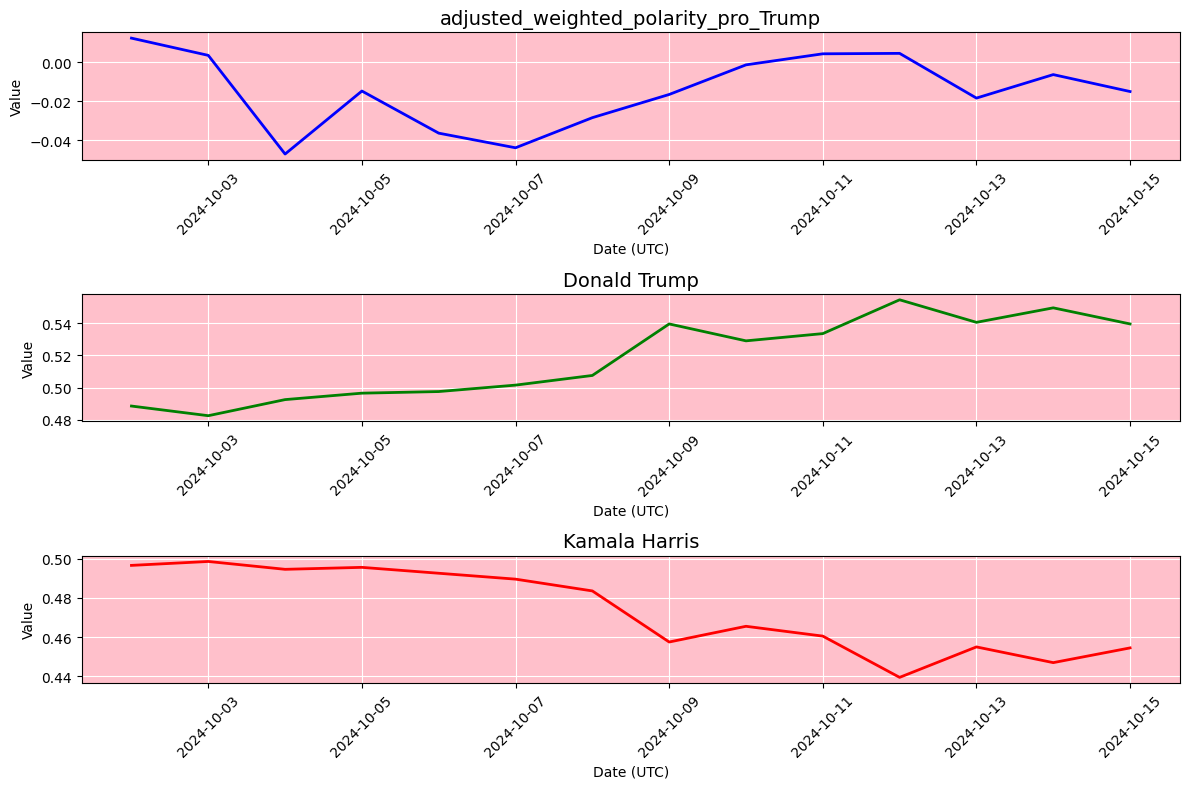

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

# Define colors for each series
colors = ['blue', 'green', 'red']

# Create subplots for each series
for idx, (column, color) in enumerate(zip(['adjusted_weighted_polarity_pro_Trump', 'Donald Trump', 'Kamala Harris'], colors)):
    plt.subplot(3, 1, idx + 1)
    plt.plot(df.index, df[column], label=column, color=color, linewidth=2)
    plt.gca().set_facecolor('#FFC0CB')  # Pink background for each subplot
    plt.title(column, fontsize=14)
    plt.xlabel('Date (UTC)', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, color='white')
    plt.tight_layout()

# Display the faceted plots
plt.tight_layout()
plt.show()

From the graph above, we observe that on dates with a higher number of observations, **our analysis aligns with the overall trend seen on Polymarket.**  This suggests that our analysis has **some explanatory power.**

For 10-03 - 1007, **the volatility (failed trend)** in our analysis is primarily due to the limited data collected, making it susceptible to the **angry man effect**. Despite applying weighting methods, it remains challenging to accurately capture true market sentiments with such limited data.

During 10-09 - 10-15, our analysis successfully identified the broader market trend but **struggled to detect more subtle shifts.** This issue likely arises from data quality concerns (including a significant amount of irrelevant text) and our difficulty in assigning sentiment to tweets that mention both sides (resulting in ambiguity, so we just make them neutral). Including such tweets reduced **the average polarity scale** each day. Nonetheless, using the methodology mentioned earlier, we successfully translated tweets about Harris into negative Trump, treated irrelevant/both comments about Trump as noise/neutral, and adjusted our analysis accordingly. This may have contributed to our success of capturing overall market dynamics.

With more time for manual review or access to better data, we hope to enhance our analysis in the future. For now, we will conclude our analysis here.

# Market Analysis

Russell 2000: The Russell 2000 is an index measuring the performance of approximately 2,000 small-cap companies in the United States. It is often considered a benchmark for the health of small-cap stocks. **Small-cap stocks are more sensitive** to changes in domestic policies, including trade policies, tax reforms, and regulations, because smaller companies often have a higher proportion of their revenues coming from within the U.S. compared to larger multinational corporations.

The Dollar Index (DXY) measures the **value of the U.S. dollar relative to a basket of foreign currencies**, including the euro, yen, pound, Canadian dollar, Swedish krona, and Swiss franc.

It is a key indicator of the strength of the U.S. dollar in the global market. Factors such as interest rate changes by the Federal Reserve, global economic conditions, and geopolitical events can impact the Dollar Index.

#### Hypothesis:

When market sentiment towards Trump is positive (e.g., expectations of tax cuts, deregulation, or pro-business policies), **the Russell 2000 often performs well.** This is because small-cap stocks are sensitive to domestic economic policies, and such policies are perceived as beneficial for smaller businesses.

When Trump’s actions are viewed positively (e.g., expectations of stronger economic growth due to deregulation or tax cuts), **the Dollar Index may rise** as expectations of better U.S. economic performance increase demand for the dollar.


In [54]:
import yfinance as yf
# Define the symbols for Dollar Index and Russell 2000
dollar_symbol = 'DX-Y.NYB'  # Dollar Index symbol might vary; 'DX-Y.NYB' is used here for illustration
russell_symbol = '^RUT'     # Russell 2000 symbol

# Define the date range for your analysis
start_date = '2024-10-01'
end_date = '2024-10-17'

# Download the data for Dollar Index and Russell 2000
dollar_data = yf.download(dollar_symbol, start=start_date, end=end_date)
russell_data = yf.download(russell_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Capturing the exact timing of sentiment shifts is challenging and often speculative. To address this, we analyze both **intraday** and **next-day** percentage changes in the indicators (RUSSEL 2000 and Dollar index) here. This captures immediate market reactions and delayed responses, providing a more complete view of how sentiment influences the market in real-time and the following trading session.

In [55]:
#### RUSSLE

In [56]:
russell_data_change = russell_data['Adj Close'].pct_change()
russell_data_rt  = pd.DataFrame({
    'Russel Return': russell_data_change,
    'Next Russel Return': russell_data_change.shift(-1)
})
russell_data_rt

,Russel Return,Next Russel Return
Date,,
2024-10-01,NaN,-0.000919
2024-10-02,-0.000919,-0.006770
2024-10-03,-0.006770,0.014976
2024-10-04,0.014976,-0.008907
2024-10-07,-0.008907,0.000862
2024-10-08,0.000862,0.002556
2024-10-09,0.002556,-0.005530
2024-10-10,-0.005530,0.021015
2024-10-11,0.021015,0.006369


In [57]:
russell_data_rt = russell_data_rt.dropna()
russell_data_rt['trump_sentiment']  = poly_analysis['adjusted_weighted_polarity_pro_Trump']

<ipython-input-57-6e6525907f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russell_data_rt['trump_sentiment']  = poly_analysis['adjusted_weighted_polarity_pro_Trump']


In [58]:
russell_data_rt

,Russel Return,Next Russel Return,trump_sentiment
Date,,,
2024-10-02,-0.000919,-0.006770,0.012453
2024-10-03,-0.006770,0.014976,0.003612
2024-10-04,0.014976,-0.008907,-0.046995
2024-10-07,-0.008907,0.000862,-0.043788
2024-10-08,0.000862,0.002556,-0.028340
2024-10-09,0.002556,-0.005530,-0.016445
2024-10-10,-0.005530,0.021015,-0.001255
2024-10-11,0.021015,0.006369,0.004413
2024-10-14,0.006369,0.000525,-0.006252


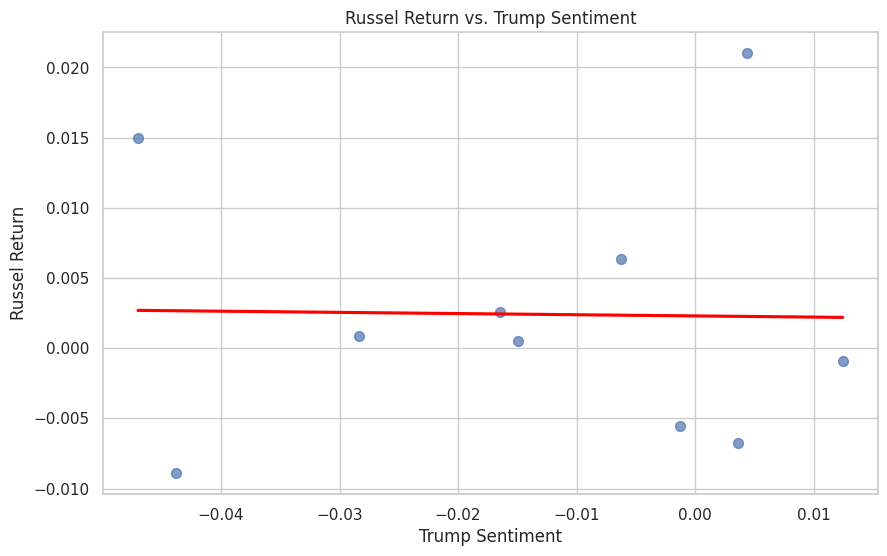

                            OLS Regression Results                            
Dep. Variable:          Russel Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                  0.002617
Date:                Mon, 21 Oct 2024   Prob (F-statistic):              0.960
Time:                        02:04:03   Log-Likelihood:                 32.904
No. Observations:                  10   AIC:                            -61.81
Df Residuals:                       8   BIC:                            -61.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0023      0.004     

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [59]:
import seaborn as sns
import statsmodels.api as sm
x = russell_data_rt['trump_sentiment']
y = russell_data_rt['Russel Return']

# Plot using seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, ci=None, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={"color": "red"})
plt.title('Russel Return vs. Trump Sentiment')
plt.xlabel('Trump Sentiment')
plt.ylabel('Russel Return')
plt.show()

# Add a constant for the linear regression model
x_with_const = sm.add_constant(x)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, x_with_const).fit()

# Print the regression summary
print(model.summary())

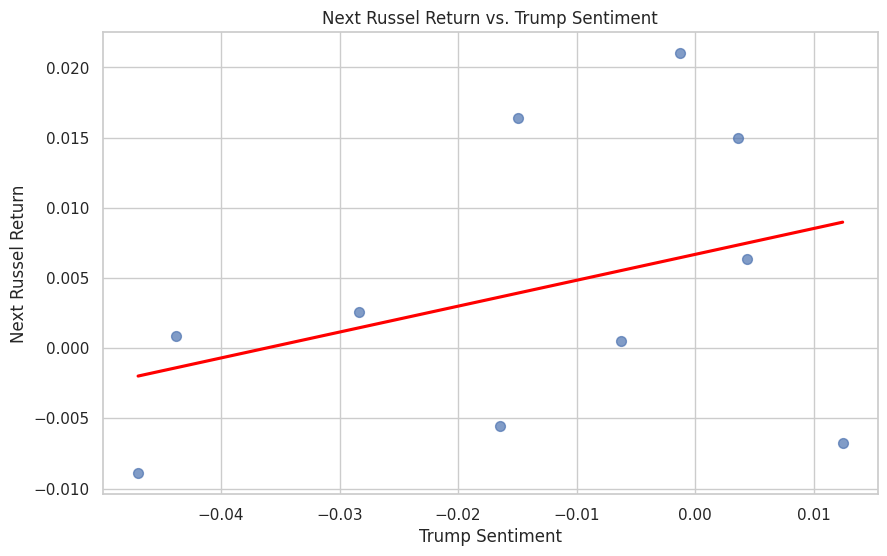

                            OLS Regression Results                            
Dep. Variable:     Next Russel Return   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.220
Date:                Mon, 21 Oct 2024   Prob (F-statistic):              0.301
Time:                        02:04:04   Log-Likelihood:                 32.744
No. Observations:                  10   AIC:                            -61.49
Df Residuals:                       8   BIC:                            -60.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0067      0.004     

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [60]:
x = russell_data_rt['trump_sentiment']
y = russell_data_rt['Next Russel Return']

# Plot using seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, ci=None, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={"color": "red"})
plt.title('Next Russel Return vs. Trump Sentiment')
plt.xlabel('Trump Sentiment')
plt.ylabel('Next Russel Return')
plt.show()

# Add a constant for the linear regression model
x_with_const = sm.add_constant(x)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, x_with_const).fit()

# Print the regression summary
print(model.summary())

The **intraday** regression results show a nearly flat line with a negative coefficient (-0.0084)
and a high p-value (0.960), indicating no statistically significant impact of sentiment on same-day returns.
The R-squared value of 0.000 suggests the model does not explain any variation in intraday returns.

For the **next-day** analysis, the coefficient is **slightly positive (0.1844)** but still has a relatively high p-value (0.301).
However, the R-squared value (0.132) shows a slight increase in explanatory power, suggesting a **weak relationship**
between Trump sentiment and next-day Russell 2000 returns.

The small sample size of only 10 observations likely contributes to the lack of significant results, making it harder to detect meaningful relationships and increasing the influence of outliers.  

The linear model may not capture complex or delayed market reactions to sentiment, and our simplified sentiment measure might miss nuances due to data quality limitations. A larger dataset, non-linear models, and a longer tracking period would improve the analysis. However, without access to Tweepy APIs, extending the tracking period to 3 months isn't possible for now.


Then we examine the relationship between postive sentiment towards Trump and trend of Dollar index.


In [61]:
# DOLLAR
dollar_pct_change = dollar_data['Adj Close'].pct_change()

# Create a DataFrame with the percentage change and a shifted version
dollar_data_rt  = pd.DataFrame({
    'Dollar_Pct_Change': dollar_pct_change,
    'Shifted_Pct_Change': dollar_pct_change.shift(-1)
})

# Display the resulting DataFrame
dollar_data_rt

,Dollar_Pct_Change,Shifted_Pct_Change
Date,,
2024-10-01,NaN,0.004842
2024-10-02,0.004842,0.003049
2024-10-03,0.003049,0.005197
2024-10-04,0.005197,0.000195
2024-10-07,0.000195,0.000098
2024-10-08,0.000098,0.003705
2024-10-09,0.003705,0.000583
2024-10-10,0.000583,-0.000971
2024-10-11,-0.000971,0.003985


In [62]:
dollar_data_rt = dollar_data_rt.dropna()
dollar_data_rt['trump_sentiment']  = poly_analysis['adjusted_weighted_polarity_pro_Trump']

<ipython-input-62-f7e54094f0c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dollar_data_rt['trump_sentiment']  = poly_analysis['adjusted_weighted_polarity_pro_Trump']


In [63]:
dollar_data_rt

,Dollar_Pct_Change,Shifted_Pct_Change,trump_sentiment
Date,,,
2024-10-02,0.004842,0.003049,0.012453
2024-10-03,0.003049,0.005197,0.003612
2024-10-04,0.005197,0.000195,-0.046995
2024-10-07,0.000195,0.000098,-0.043788
2024-10-08,0.000098,0.003705,-0.028340
2024-10-09,0.003705,0.000583,-0.016445
2024-10-10,0.000583,-0.000971,-0.001255
2024-10-11,-0.000971,0.003985,0.004413
2024-10-14,0.003985,-0.000387,-0.006252


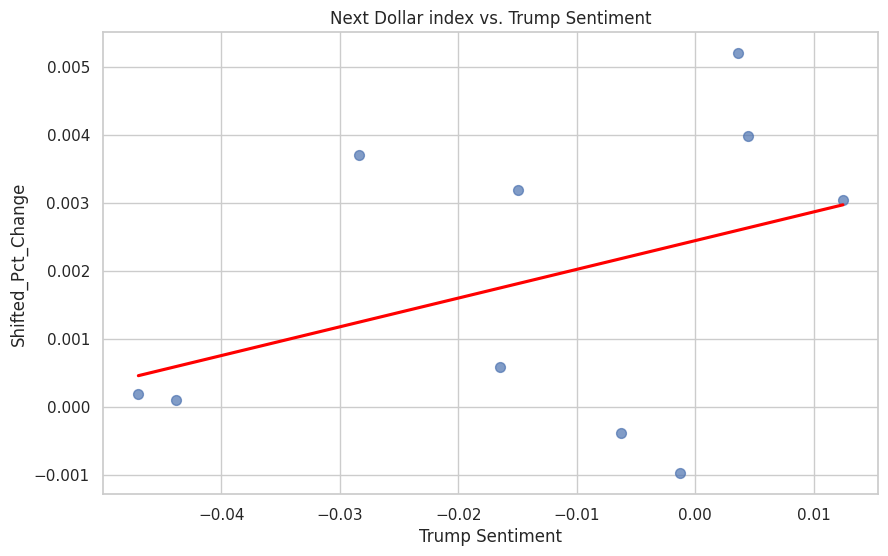

                            OLS Regression Results                            
Dep. Variable:     Shifted_Pct_Change   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.483
Date:                Mon, 21 Oct 2024   Prob (F-statistic):              0.258
Time:                        02:04:05   Log-Likelihood:                 48.466
No. Observations:                  10   AIC:                            -92.93
Df Residuals:                       8   BIC:                            -92.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0024      0.001     

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [64]:
x = dollar_data_rt['trump_sentiment']
y = dollar_data_rt['Shifted_Pct_Change']

# Plot using seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, ci=None, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={"color": "red"})
plt.title('Next Dollar index vs. Trump Sentiment')
plt.xlabel('Trump Sentiment')
plt.ylabel('Shifted_Pct_Change')
plt.show()

# Add a constant for the linear regression model
x_with_const = sm.add_constant(x)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, x_with_const).fit()

# Print the regression summary
print(model.summary())

For the Dollar Index, the analysis shows a **weak positive** relationship between Trump sentiment and the **next day’s** percentage change. The regression coefficient of 0.0422 suggests that a one-unit increase in Trump sentiment corresponds to a 0.0422% rise in the next day’s Dollar Index, reflecting stronger confidence in the dollar. However, this relationship is not statistically significant, with a high p-value of 0.258. The R-squared value of 0.156 indicates that Trump sentiment explains only 15.6% of the variation in the Dollar Index.

Although our hypothesis suggests that Trump’s sentiment may have a positive impact on both the Dollar Index and Russell 2000, the **small sample size** of just 10 observations significantly **limits the reliability and robustness** of these findings. With such a limited dataset, it becomes challenging to identify meaningful relationships, and the results are more susceptible to the influence of outliers. As a result, the current analysis lacks the statistical power needed to draw firm conclusions. To improve the accuracy and confidence in these sentiment-based strategies, it would be essential to gather more data over a longer period, apply deeper analysis techniques, and incorporate more advanced tools.